Plants Diseases Classification Model :

In [1]:
# Used Libraries & Independences :
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('dark')

In [2]:
# Dataset Ingestion :
size_of_image = 256
size_of_batch = 32
channels = 3
n_classes = 3
epochs = 50
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"D:\Fasila - Graduation Project\PlantVillage",
    shuffle = True,
    image_size = size_of_image,
    batch_size = size_of_batch
)

Found 2152 files belonging to 3 classes.


In [3]:
# Our Classes :
classes = dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [4]:
# Handling Classes Naming :
classes[0] = 'Early Blight'
classes[1] = 'Late Blight'
classes[2] = 'Healthy : No Diseases'
classes

['Early Blight', 'Late Blight', 'Healthy : No Diseases']

In [5]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
# Check Shape Of All Batch :
for image_batch, labels in dataset.take(1) :
    print(image_batch.shape)
    print(labels.numpy())

(32, 256, 256, 3)
[1 0 2 0 1 0 2 0 0 2 1 0 0 1 0 1 0 1 1 1 1 2 1 1 0 2 1 1 0 1 1 1]


In [7]:
# Check Shape Of First Image :
for image_batch, labels in dataset.take(1) :
    print(image_batch[0].shape)
    print(labels[0].numpy())

(256, 256, 3)
1


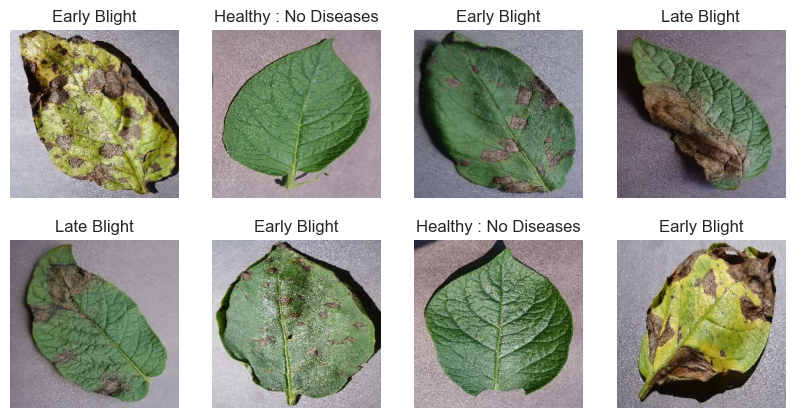

In [8]:
# Visualizing Some Image With Labels :
plt.figure(figsize=(10, 5))
for image_batch, labels in dataset.take(1) :
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[labels[i].numpy()])
        plt.axis("off")

In [9]:
# Dataset Spiliting :
def partitioning_dataset(data, train_per = 0.8, val_per = 0.1, test_per = 0.1, shuffle = True, shuffle_size = 100):
    data_size = len(data)
    if shuffle:
        data = data.shuffle(shuffle_size, seed = 42)
        
    train_size = int(data_size * train_per)
    val_size = int(data_size * val_per)
    
    train_dataset = data.take(train_size)
    val_dataset = data.skip(train_size).take(val_size)
    test_dataset = data.skip(train_size).skip(val_size)

    return train_dataset, val_dataset, test_dataset

In [10]:
train_dataset, val_dataset, test_dataset = partitioning_dataset(dataset)

In [11]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

54
6
8


In [12]:
# Improve Performance :
train_dataset = train_dataset.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)

In [13]:
# Images Preprocessing :
resizing_and_rescaling = tf.keras.Sequential([
    layers.Resizing(size_of_image, size_of_image),
    layers.Rescaling(1.0 / 255.0)
])

In [14]:
# Data Augmentation : 
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [15]:
# Building C-NN Model :
shape_of_input = (size_of_batch, size_of_image, size_of_image, channels)
cnn_model = models.Sequential([
    resizing_and_rescaling,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = shape_of_input),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

cnn_model.build(shape_of_input)

C:\Users\Tarek\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Model Compiling :
cnn_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [18]:
# Model Training :
model_history = cnn_model.fit(
    train_dataset,
    epochs = epochs,
    batch_size = size_of_batch,
    verbose = 1,
    validation_data = val_dataset
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.4380 - loss: 0.9333 - val_accuracy: 0.7083 - val_loss: 0.8785
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.6511 - loss: 0.7563 - val_accuracy: 0.7917 - val_loss: 0.4972
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8276 - loss: 0.4000 - val_accuracy: 0.8125 - val_loss: 0.4116
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8723 - loss: 0.3273 - val_accuracy: 0.9115 - val_loss: 0.2242
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9094 - loss: 0.2148 - val_accuracy: 0.9323 - val_loss: 0.1989
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9152 - loss: 0.2044 - val_accuracy: 0.9219 - val_loss: 0.2067
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9204 - loss: 0.1992 - val_accuracy: 0.9479 - val_loss: 0.1660
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9440 - loss: 0.1673 - val_accuracy: 0.8802 - val_loss:

In [19]:
# Evaluate With Testing Dataset :
test_accuracy = cnn_model.evaluate(test_dataset)
test_accuracy

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - accuracy: 0.9566 - loss: 0.0970


[0.11821971833705902, 0.9453125]

In [20]:
model_history

In [21]:
model_history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [22]:
model_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [23]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

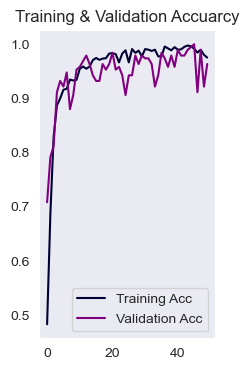

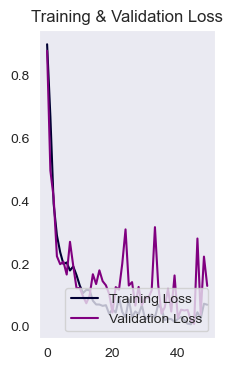

In [24]:
# Visualizing Training & Validation ( Accuracy & Loss ) :
plt.figure(figsize = (5, 4))
plt.subplot(1, 2, 1)
plt.plot(range(int(epochs)), accuracy, label = 'Training Acc', color = '#000033')
plt.plot(range(int(epochs)), val_accuracy, label = 'Validation Acc', color = 'purple')
plt.legend(loc = 'lower right')
plt.title("Training & Validation Accuarcy")

plt.figure(figsize = (5, 4))
plt.subplot(1, 2, 2)
plt.plot(range(int(epochs)), loss, label = 'Training Loss', color = '#000033')
plt.plot(range(int(epochs)), val_loss, label = 'Validation Loss', color = 'purple')
plt.legend(loc = 'lower right')
plt.title("Training & Validation Loss")
plt.show()

This is Image to Predict
It's Label : Early Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
Predition : Early Blight


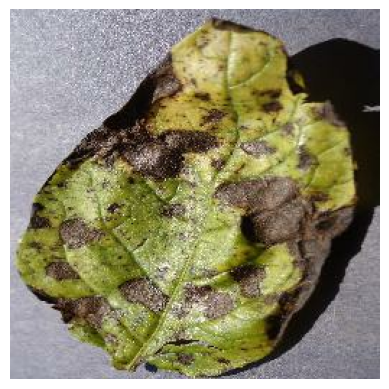

In [25]:
for batch_images, batch_labels in test_dataset.take(1) :
    first_image = plt.imshow(batch_images[0].numpy().astype('uint8'))
    first_image_label = batch_labels[0].numpy()
    print("This is Image to Predict")
    print(f"It's Label : {classes[first_image_label]}")
    
    # Prediction & Evaluation On Simple One Image :
    prediction = cnn_model.predict(batch_images)
    print(f"Predition : {classes[np.argmax(prediction[0])]}")
    plt.axis('off')

In [26]:
# Make Simple Prediction System :
def get_prediction(model, img) :
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    prediction = model.predict(img_array)
    prediction_class = classes[np.argmax(prediction[0])]
    confidence_score = round(100 * (np.max(prediction[0])), 2)
    return prediction_class, confidence_score

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


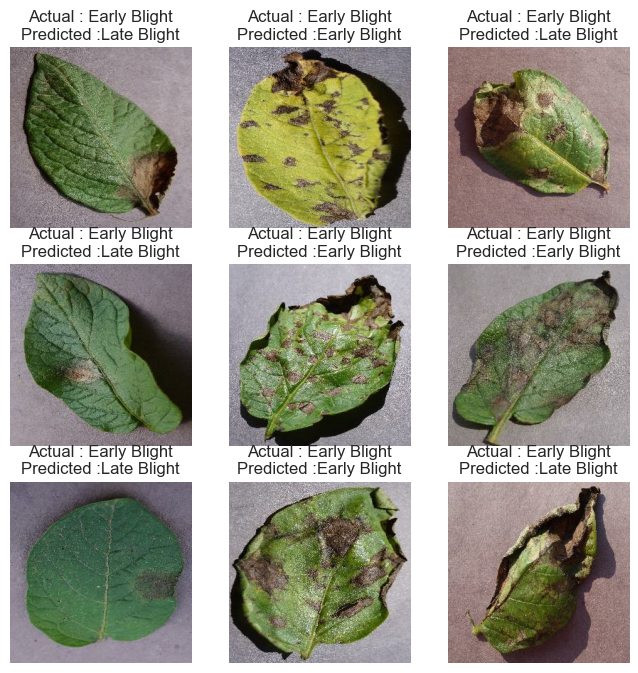

In [30]:
plt.figure(figsize = (8,8))
for images, lables in test_dataset.take(1) :
    for i in range(9) :
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = get_prediction(cnn_model, images[i].numpy())
        actual_class = classes[labels[0]]
        plt.title(f"Actual : {actual_class}\nPredicted :{predicted_class}")
        plt.axis("off")

In [40]:
# Saving Model Locally :
cnn_model.export(r"D:\Fasila - Graduation Project\CNN Model")

INFO:tensorflow:Assets written to: D:\Fasila - Graduation Project\CNN Model\assets


INFO:tensorflow:Assets written to: D:\Fasila - Graduation Project\CNN Model\assets


Saved artifact at 'D:\Fasila - Graduation Project\CNN Model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1626009705488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1626009705680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1626009707600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1626009708752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1626009707792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1626009710288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1626009709136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1626009710672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1626009710096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1626009711056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1626009710